In [1]:
import sys, os
sys.path.append(os.getcwd() + os.sep + os.pardir)

In [2]:
%matplotlib inline
from sklearn.datasets import load_boston
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

# Predicting House Prices With Linear Regression

This is the second notebook I write related to linear regression, because it's time to apply this model to a real dataset, starting with the Boston housing dataset. In this problem we want to predict the median value of houses given 13 input variables.

In [3]:
data_bunch = load_boston()
X = data_bunch['data']
T = data_bunch['target'][:, np.newaxis]
n_features = X.shape[1]
n_samples = X.shape[0]
print("Number of features: {:d}".format(n_features))
print("Number of samples: {:d}".format(n_samples))

Number of features: 13
Number of samples: 506


Since the targets are one dimensional, we can easily visualize them.

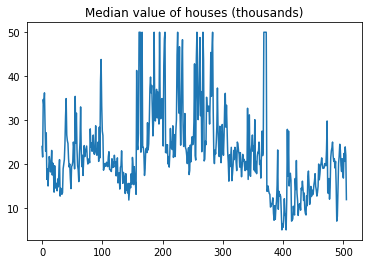

In [4]:
plt.plot(T)
plt.title("Median value of houses (thousands)");

There seems to be some special order in the data so we will shuffle it first and then split into training (70%) and test (30%) sets.

In [5]:
idx = np.random.permutation(n_samples)
X = X[idx]
T = T[idx]
split_idx = int(0.7 * n_samples)
X_train = X[:split_idx]
T_train = T[:split_idx]
X_test = X[split_idx:]
T_test = T[split_idx:]
n_train_samples = X_train.shape[0]
n_test_samples = X_test.shape[0]

We will now use the training data to train a regularized linear regression model. In order to find a regularization factor $\lambda$ that increases the generalization properties of the model, we will use cross-validation with 5 folds, and we will pick the value of $\lambda$ that produces the lowest Root Mean Square Error (RMSE) averaged over all folds.

In [6]:
from linear_regression import LinearRegression
from data.utils import crossval_indices
from metrics.regression import rmse

In [7]:
# Get training and validation indices
n_folds = 5
train_folds, valid_folds = crossval_indices(n_train_samples, n_folds)

# Train with different regularization factors
best_error = float('inf')
best_lamb = 0
for lamb in (0.1, 1, 10, 20):
    error = 0
    model = LinearRegression(lamb)
    for fold in range(n_folds):
        # Get indices for the current fold
        train_idx = train_folds[fold]
        val_idx = valid_folds[fold]
        # Train model
        model.fit(X_train[train_idx], T_train[train_idx])
        # Get predictions on validation set and evaluate RMSE
        Y = model.predict(X_train[val_idx])        
        error += rmse(Y, T_train[val_idx])
    # Calculate cross-validation error
    error /= n_folds
    if error < best_error:
        best_error = error
        best_lamb = lamb
        
print("Lowest error: {:.4f}, with lambda = {:.2f}".format(best_error, best_lamb))

Lowest error: 5.1717, with lambda = 10.00


We can now train the model with the best hyperparameter found and examine the resulting residuals:

RMSE: 4.9919


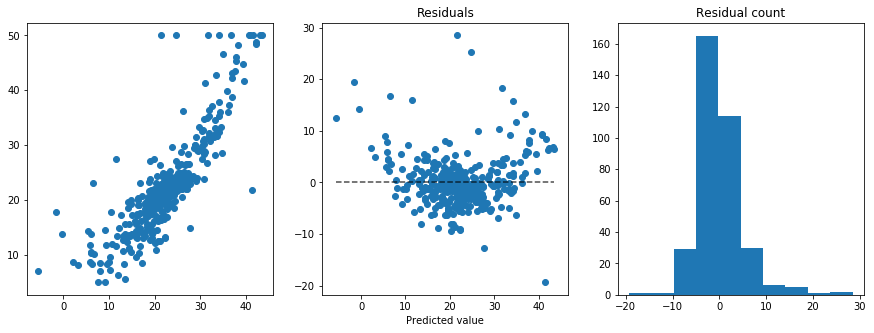

In [8]:
# Train model with best lambda found
model = LinearRegression(lamb=10)
model.fit(X_train, T_train)
Y = model.predict(X_train)
error = rmse(Y, T_train)
print("RMSE: {:.4f}".format(error))
# Plot residuals
residuals = T_train - Y
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.scatter(Y, T_train)
plt.subplot(1, 3, 2)
plt.title("Residuals")
plt.xlabel("Predicted value")
plt.plot([min(Y), max(Y)], [0, 0], 'k--', alpha=0.7)
plt.scatter(Y, residuals)
plt.subplot(1, 3, 3)
plt.title("Residual count")
plt.hist(residuals);

We can see that, apart from some outliers, towards the ends of the predictions range the model tends to predict lower values than the real ones, thus suggesting a more complex model or extracting non-linear features from the data (such as quadratic terms).
We can get a final measure of performance from the model by evaluating the RMSE on the test set, which was not used for hyperparameter optimization.

In [9]:
Y_test = model.predict(X_test)
error = rmse(Y_test, T_test)
print("RMSE: {:.4f}".format(error))

RMSE: 4.9331
